In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install opencv-python-headless
!pip install tensorflow



In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shiprasng02","key":"f52da35f8c39ec3c61f137db73f2e39b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [ ]:
!kaggle datasets download -d adityajn105/flickr8k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0


In [ ]:
!unzip flickr8k.zip -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/dataset/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/dataset/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/dataset/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/dataset/Images/2846037553_1a1de50709.jpg  
  inflating: /content/dataset/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/dataset/Images/2846843520_b0e6211478.jpg  
  inflating: /content/dataset/Images/2847514745_9a35493023.jpg  
  inflating: /content/dataset/Images/2847615962_c330bded6e.jpg  
  inflating: /content/dataset/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/dataset/Images/2848266893_9693c66275.jpg  
  inflating: /content/dataset/Images/2848571082_26454cb981.jpg  
  inflating: /content/dataset/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/dataset/Images/2848977044_446a31d86e.jpg  
  inflating: /content/dataset/Images/28

import os

# See what's actually there
print(os.listdir('/content/dataset'))


In [ ]:
import os

base_path = '/content/dataset'
for root, dirs, files in os.walk(base_path):
    if len(files) > 0 and files[0].endswith(('.jpg', '.jpeg', '.png')):
        image_folder = root
        print(f"Found image folder: {image_folder}")
        break


Found image folder: /content/dataset/Images


In [ ]:
import os

base_path = '/content/dataset'
for root, dirs, files in os.walk(base_path):
    if len(files) > 0 and files[0].endswith(('.jpg', '.jpeg', '.png')):
        image_folder = root
        print(f"Found image folder: {image_folder}")
        break


Found image folder: /content/dataset/Images


In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# Set up parameters
IMAGE_SIZE = 128  # You can change to 256 if you want higher resolution
NUM_IMAGES = 5000  # Limit for quicker training/testing during dev

input_images = []   # Grayscale
target_images = []  # RGB

# Loop through images
image_files = os.listdir(image_folder)[:NUM_IMAGES]

for file in tqdm(image_files):
    img_path = os.path.join(image_folder, file)

    # Load color image
    img = cv2.imread(img_path)
    if img is None:
        continue  # skip if image can't be read

    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Normalize
    img_gray = img_gray / 255.0
    img_rgb = img_rgb / 255.0

    # Add channel dimension to grayscale
    img_gray = np.expand_dims(img_gray, axis=-1)

    input_images.append(img_gray)
    target_images.append(img_rgb)

# Convert to NumPy arrays
X = np.array(input_images)
Y = np.array(target_images)

print("Input shape (grayscale):", X.shape)
print("Target shape (color):", Y.shape)


100%|██████████| 5000/5000 [00:17<00:00, 286.46it/s]


Input shape (grayscale): (5000, 128, 128, 1)
Target shape (color): (5000, 128, 128, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Activation

def build_autoencoder(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)

    x = UpSampling2D((2, 2))(x)
    outputs = Conv2DTranspose(3, (3, 3), padding='same', activation='sigmoid')(x)  # 3 channels for RGB

    model = Model(inputs, outputs)
    return model


In [ ]:
model = build_autoencoder()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 740,227 (2.82 MB)

 Trainable params: 740,227 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")


Training samples: 4500, Validation samples: 500


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")


Training samples: 4500, Validation samples: 500


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('colorization_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,            # You can increase for better quality
    batch_size=32,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4193 - loss: 0.0412

141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.4194 - loss: 0.0411 - val_accuracy: 0.4722 - val_loss: 0.0195
Epoch 2/5
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4430 - loss: 0.0188

141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.4430 - loss: 0.0188 - val_accuracy: 0.4673 - val_loss: 0.0176
Epoch 3/5
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4421 - loss: 0.0173

141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.4422 - loss: 0.0173 - val_accuracy: 0.4637 - val_loss: 0.0169
Epoch 4/5
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4506 - loss: 0.0167

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.4507 - loss: 0.0167 - val_accuracy: 0.4558 - val_loss: 0.0161
Epoch 5/5
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4736 - loss: 0.0156

141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.4736 - loss: 0.0156 - val_accuracy: 0.4590 - val_loss: 0.0151


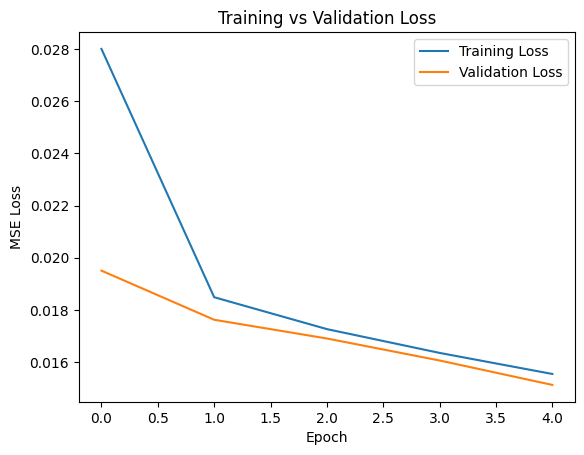

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Predict on a few grayscale images from validation set
predictions = model.predict(X_val[:5])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


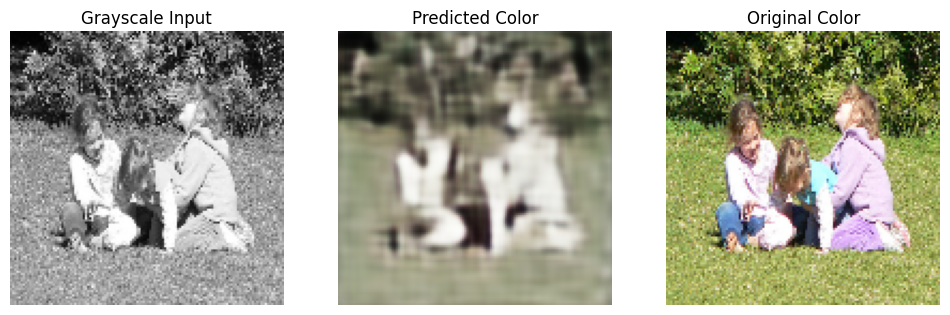

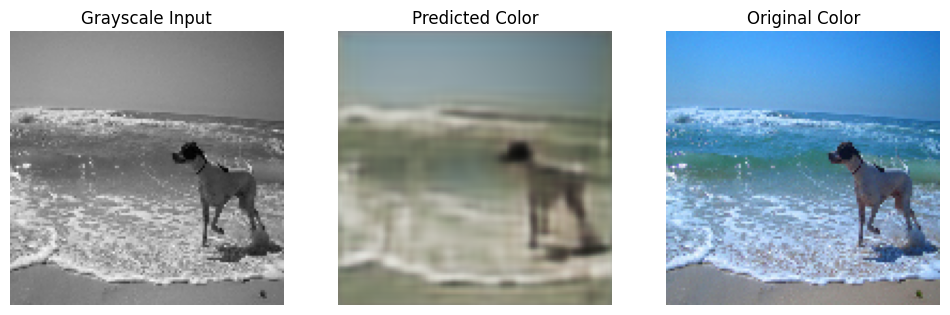

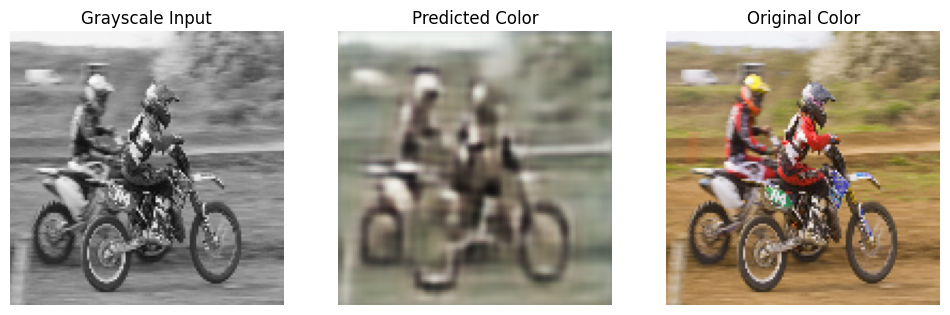

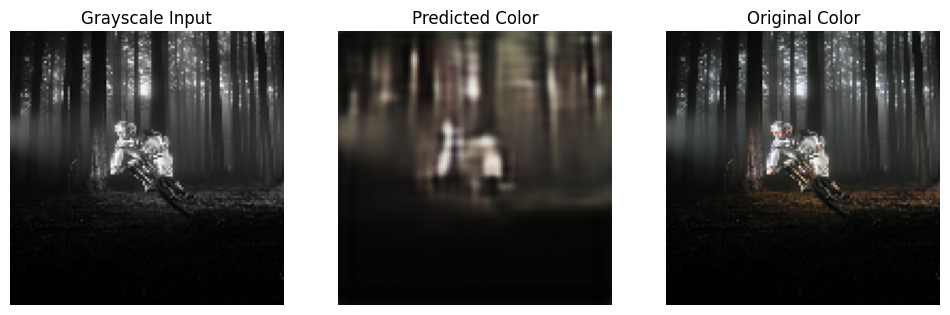

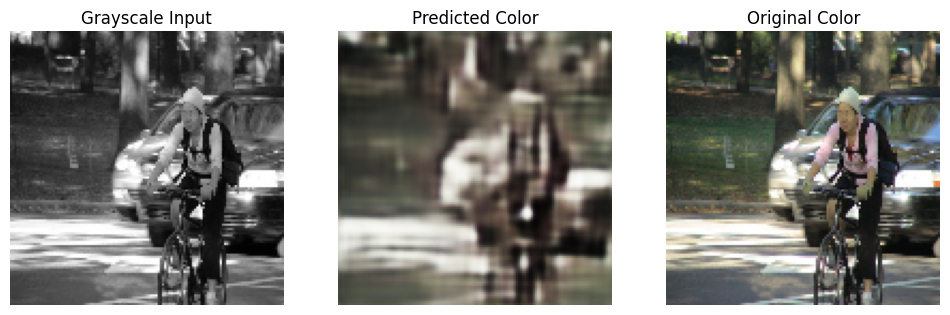

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure(figsize=(12, 4))

    # Grayscale Input
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.title("Grayscale Input")
    plt.axis('off')

    # Predicted Color
    plt.subplot(1, 3, 2)
    plt.imshow(predictions[i])
    plt.title("Predicted Color")
    plt.axis('off')

    # Original Color
    plt.subplot(1, 3, 3)
    plt.imshow(Y_val[i])
    plt.title("Original Color")
    plt.axis('off')

    plt.show()


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])


In [ ]:
model.save('my_colorization_model.h5')


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('my_colorization_model.h5')
